In [29]:
import pandas as pd
import json
import re
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.corpus import stopwords
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objs as go

In [30]:
# Load NLTK stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ritutoshniwal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [31]:
# Load JSON data
with open('updated_articles.json', 'r') as file:
    data = json.load(file)

# Convert JSON data to DataFrame
articles = pd.DataFrame(data)

In [32]:
def preprocess_text(text):
    text = re.sub('[,\.!?]', '', text)
    text = text.lower()
    return text

In [33]:
articles['text_processed'] = articles['body'].apply(preprocess_text)

In [34]:
# Tokenize and remove stopwords
def remove_stopwords(texts):
    return [[word for word in re.findall(r'\b\w+\b', doc) if word not in stop_words] for doc in texts]

In [35]:
data = articles['text_processed'].values.tolist()
data_words = remove_stopwords(data)

In [36]:
# Rejoin words to prepare for CountVectorizer
data_words_joined = [" ".join(doc) for doc in data_words]

# Create CountVectorizer and transform the data
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
data_vectorized = vectorizer.fit_transform(data_words_joined)

In [38]:
# Build LDA model using sklearn
num_topics = 3
lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=0)
lda_model.fit(data_vectorized)

LatentDirichletAllocation(n_components=3, random_state=0)

In [39]:
# Save the embedding vectors/weights for TSNE
lda_weights = lda_model.transform(data_vectorized)
lda_weights_df = pd.DataFrame(lda_weights)
lda_weights_df.to_csv('lda_weights.csv', index=False)

In [41]:
articles['true_narrative']

0     1
1     3
2     2
3     3
4     2
5     2
6     1
7     2
8     3
9     3
10    1
11    2
12    1
13    3
14    1
15    2
Name: true_narrative, dtype: int64

### SLDA

In [49]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import StratifiedShuffleSplit

In [45]:
# Load the LDA weights
lda_weights_df = pd.read_csv('lda_weights.csv')
true_narrative = [1,3,2,3,2,2,1,2,3,3,1,2,1,3,1,2] # Replace with your actual data
lda_weights_df['true_narrative'] = true_narrative

In [46]:
# feature matrix X and target vector y
X = lda_weights_df.drop('true_narrative', axis=1)
y = lda_weights_df['true_narrative']

In [52]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the Logistic Regression model
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

# Make predictions on the test set
y_pred = log_reg.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(report)

Accuracy: 0.5
Classification Report:
              precision    recall  f1-score   support

           1       0.50      0.50      0.50         2
           2       0.50      1.00      0.67         1
           3       0.00      0.00      0.00         1

    accuracy                           0.50         4
   macro avg       0.33      0.50      0.39         4
weighted avg       0.38      0.50      0.42         4



/Users/ritutoshniwal/Code/news_analysis/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/ritutoshniwal/Code/news_analysis/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Users/ritutoshniwal/Code/news_analysis/env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [59]:
def v_2d_csv(filename):
    df = pd.read_csv(filename)
    data = df.values
    print(data.shape)
    
    # Check the number of samples
    n_samples = data.shape[0]

    # Set the perplexity parameter to be less than the number of samples
    perplexity = min(30, n_samples - 1)

    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
    v_2d = tsne.fit_transform(data)
    print(v_2d.shape)
    
    df_2d = pd.DataFrame(v_2d, columns=['x', 'y'])
    df_2d.to_csv("v_2d.csv", index=False)

In [27]:
"""def test_tsne_plot(filename):
    df = pd.read_csv(filename)
    data = df.values
    tsne = TSNE(n_components=2, random_state=42)
    v_2d = tsne.fit_transform(data)
    
    plt.figure(figsize=(10, 8))
    v_2d_gaza = np.concatenate((v_2d[:100], v_2d[400:500]))
    v_2d_election = np.concatenate((v_2d[100:200], v_2d[300:400]))
    v_2d_dispute = np.concatenate((v_2d[200:300], v_2d[500:600]))

    for index, (x, y) in enumerate(v_2d_gaza):
        plt.scatter(
            x, 
            y, 
            alpha=0.4, 
            color="blue",
            s=3, 
            label="Gaza" if index == 0 else "")

    for index, (x, y) in enumerate(v_2d_election):
        plt.scatter(
            x,
            y,
            alpha=0.4,
            color="green",
            s=3,
            label="India Election" if index == 0 else "",
        )

    for index, (x, y) in enumerate(v_2d_dispute):
        plt.scatter(
            x,
            y,
            alpha=0.4,
            color="red",
            s=3,
            label="South China Sea Dispute" if index == 0 else "",
        )
    plt.title(
        f"LDA t-SNE visualization of document embeddings"
    )

    plt.xlabel("t-SNE component 1")
    plt.ylabel("t-SNE component 2")
    plt.legend()
    plt.show()"""

In [63]:
def test_tsne_plot(filename):
    df = pd.read_csv(filename)
    v_2d = df.values
    
    true_narrative = np.array([1, 3, 2, 3, 2, 2, 1, 2, 3, 3, 1, 2, 1, 3, 1, 2])

    plt.figure(figsize=(10, 8))

    v_2d_1 = v_2d[np.where(true_narrative == 1)]
    v_2d_2 = v_2d[np.where(true_narrative == 2)]
    v_2d_3 = v_2d[np.where(true_narrative == 3)]

    plt.scatter(v_2d_1[:, 0], v_2d_1[:, 1], alpha=0.4, color="blue", s=3, label="Narrative 1")
    plt.scatter(v_2d_2[:, 0], v_2d_2[:, 1], alpha=0.4, color="green", s=3, label="Narrative 2")
    plt.scatter(v_2d_3[:, 0], v_2d_3[:, 1], alpha=0.4, color="red", s=3, label="Narrative 3")

    plt.title("LDA t-SNE visualization of document embeddings")
    plt.xlabel("t-SNE component 1")
    plt.ylabel("t-SNE component 2")
    plt.legend()
    plt.show()

In [60]:
v_2d_csv("lda_weights.csv",)

(16, 3)
(16, 2)


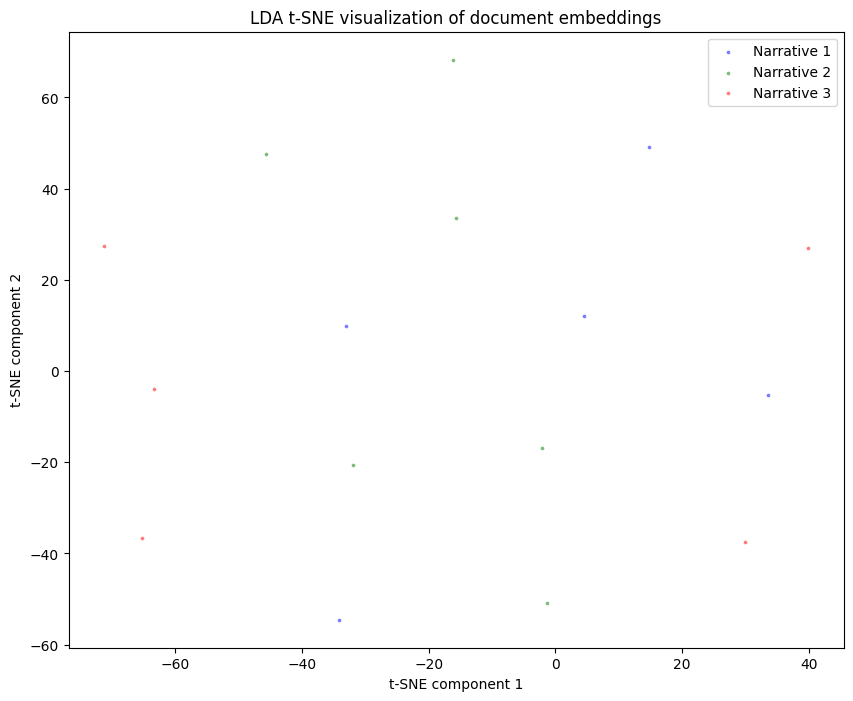

In [64]:
test_tsne_plot("v_2d.csv")

In [34]:
def interactive_tsne_plot(filename, combined_summary):
    # Load the 2D embeddings and the summaries
    v_2d_df = pd.read_csv(filename)
    v_2d_df["language"] = ["English"] * 300 + ["Hindi"] * 100 + ["Chinese"] * 200
    # Example summary data (you should use the actual combined_summary data)
    v_2d_df["summary"] = [item["summary"].strip() for item in combined_summary]
    v_2d_df["topic"] = ["Gaza"] * 100 + ["India Election"] * 100 + ["South China Sea Dispute"] * 100 + ["India Election"] * 100 + ["Gaza"] * 100 + ["South China Sea Dispute"] * 100

    # Function to format summaries for hover text
    def format_summary(text: str) -> str:
        return text.replace("\n", "<br />")
    v_2d_df["formatted_summary"] = v_2d_df["summary"].apply(format_summary)

    # Create a color mapping for topics
    color_map = {
        "Gaza": "blue",
        "India Election": "red",
        "South China Sea Dispute": "green",
    }
    v_2d_df["color"] = v_2d_df["topic"].map(color_map)

    # Create a symbol mapping for languages
    symbol_map = {
        "English": "circle",
        "Chinese": "x",
        "Hindi": "triangle-up",
    }
    v_2d_df["symbol"] = v_2d_df["language"].map(symbol_map)

    # Create traces for each topic
    traces = []
    for topic in v_2d_df["topic"].unique():
        df = v_2d_df[v_2d_df["topic"] == topic]
        for language in df["language"].unique():
            df_language = df[df["language"] == language]
            trace = go.Scatter(
                x=df_language["x"],
                y=df_language["y"],
                mode="markers",
                name=f"{topic} ({language})",
                marker=dict(color=color_map[topic], symbol=symbol_map[language], size=8),
                customdata=df_language[["formatted_summary"]],
                hoverinfo="none",
            )
            traces.append(trace)

    # Create the layout
    layout = go.Layout(
        title=f"t-SNE Visualization of News Articles",
        xaxis=dict(title="t-SNE component 1"),
        yaxis=dict(title="t-SNE component 2"),
        showlegend=True,
    )

    # Create the figure
    fig = go.Figure(data=traces, layout=layout)

    # Save the plot as an HTML file with embedded JavaScript and CSS
    html_content = f"""
    <html>
    <head>
        <title>Interactive Plot</title>
        <script src="https://cdn.plot.ly/plotly-latest.min.js"></script>
        <style>
            #summary-box {{
                position: absolute;
                top: 10px;
                right: 10px;
                width: 400px;
                max-height: 600px;
                overflow-y: auto;
                background-color: white;
                border: 1px solid black;
                padding: 10px;
                z-index: 1000;
                white-space: pre-line;
            }}
        </style>
    </head>
    <body>
        <div id="plot">{fig.to_html(full_html=False, include_plotlyjs='cdn')}</div>
        <div id="summary-box">Hover over a point to see the summary here.</div>
        <script>
            document.addEventListener('DOMContentLoaded', function() {{
                const plotElement = document.querySelector('.plotly-graph-div');
                plotElement.on('plotly_hover', function(data) {{
                    if(data.points.length > 0) {{
                        const summary = data.points[0].customdata[0];
                        document.getElementById('summary-box').innerHTML = summary;
                    }}
                }});
                plotElement.on('plotly_unhover', function(data) {{
                    document.getElementById('summary-box').innerHTML = 'Hover over a point to see the summary here.';
                }});
            }});
        </script>
    </body>
    </html>
    """

    # Save the HTML content to a file
    with open("interactive_plot.html", "w") as f:
        f.write(html_content)

In [18]:
def interactive_tsne_plot(filename, combined_summary):
    # Load the 2D embeddings and the summaries
    v_2d_df = pd.read_csv(filename)
    v_2d_df["Narrative"] = ["Narrative 1"] * 20 + ["Narrative 2"] * 20
    v_2d_df["summary"] = [item["body"].strip() for item in combined_summary]

    def format_summary(text: str) -> str:
        return text.replace("\n", "<br />")
    v_2d_df["formatted_summary"] = v_2d_df["summary"].apply(format_summary)

    # Create a color mapping for topics
    color_map = {
        "Narrative 1": "blue",
        "Narrative 2": "red",
    }
    v_2d_df["color"] = v_2d_df["Narrative"].map(color_map)


    # Create traces for each topic
    traces = []
    for Narrative in v_2d_df["Narrative"].unique():
        df = v_2d_df[v_2d_df["Narrative"] == Narrative]
        trace = go.Scatter(
                x=df["x"],
                y=df["y"],
                mode="markers",
                name=f"{Narrative}",
                marker=dict(color=color_map[Narrative], size=8),
                customdata=df[["formatted_summary"]],
                hoverinfo="none",
            )
        traces.append(trace)

    # Create the layout
    layout = go.Layout(
        title=f"t-SNE Visualization of News Articles",
        xaxis=dict(title="t-SNE component 1"),
        yaxis=dict(title="t-SNE component 2"),
        showlegend=True,
    )

    # Create the figure
    fig = go.Figure(data=traces, layout=layout)

    # Save the plot as an HTML file with embedded JavaScript and CSS
    html_content = f"""
    <html>
    <head>
        <title>Interactive Plot</title>
        <script src="https://cdn.plot.ly/plotly-latest.min.js"></script>
        <style>
            #summary-box {{
                position: absolute;
                top: 10px;
                right: 10px;
                width: 400px;
                max-height: 600px;
                overflow-y: auto;
                background-color: white;
                border: 1px solid black;
                padding: 10px;
                z-index: 1000;
                white-space: pre-line;
            }}
        </style>
    </head>
    <body>
        <div id="plot">{fig.to_html(full_html=False, include_plotlyjs='cdn')}</div>
        <div id="summary-box">Hover over a point to see the summary here.</div>
        <script>
            document.addEventListener('DOMContentLoaded', function() {{
                const plotElement = document.querySelector('.plotly-graph-div');
                plotElement.on('plotly_hover', function(data) {{
                    if(data.points.length > 0) {{
                        const summary = data.points[0].customdata[0];
                        document.getElementById('summary-box').innerHTML = summary;
                    }}
                }});
                plotElement.on('plotly_unhover', function(data) {{
                    document.getElementById('summary-box').innerHTML = 'Hover over a point to see the summary here.';
                }});
            }});
        </script>
    </body>
    </html>
    """

    # Save the HTML content to a file
    with open("interactive_plot.html", "w") as f:
        f.write(html_content)

In [19]:
with open("gpt_generated_40.json", "r") as f:
    combined_summary = json.load(f)
interactive_tsne_plot("lda_weights.csv",combined_summary)

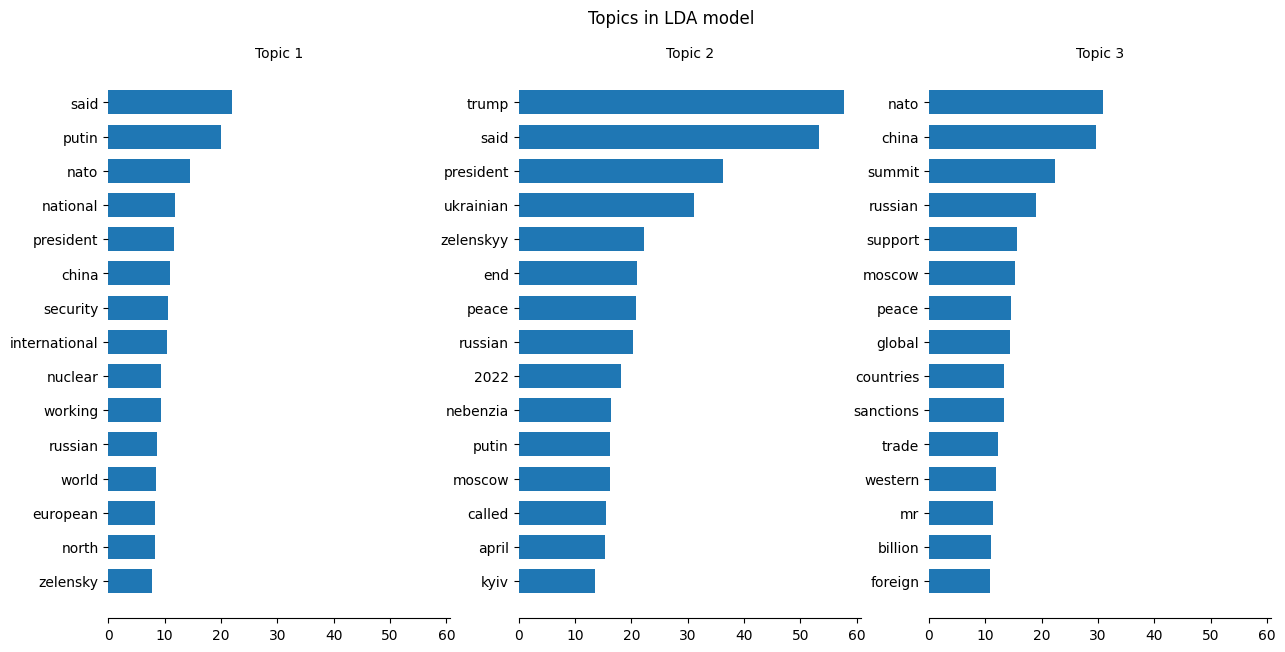

In [65]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(1, 3, figsize=(15, 7), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx + 1}', fontdict={'fontsize': 10})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=10)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
    fig.suptitle(title, fontsize=12)
    plt.subplots_adjust(top=0.90, hspace=0.3)
    plt.show()

tf_feature_names = vectorizer.get_feature_names_out()
plot_top_words(lda_model, tf_feature_names, 15, 'Topics in LDA model')